<a href="https://colab.research.google.com/github/anna-alt/AI-Lab/blob/main/SceneRecognition3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
from torchvision import models
import os
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [3]:
trainset_size = 1000
val_size = 100
num_epochs = 10
image_size = (256,256)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(image_size),
                              
                              ])
# Download and load the training data
trainset = datasets.SUN397('/content/drive/MyDrive/Data', download= False, transform=transform)
splittrain = torch.utils.data.random_split(trainset, [trainset_size, len(trainset) - trainset_size])[0]
train_loader = DataLoader(splittrain, batch_size=32,num_workers = 2, shuffle=True)

validationset = datasets.SUN397("/content/drive/MyDrive/Data", download=False, transform=transform)
splitvalidation = torch.utils.data.random_split(validationset, [val_size, len(trainset) - val_size])[0]
val_loader = DataLoader(splitvalidation, batch_size=32,num_workers = 2, shuffle=True)



In [6]:
classes = list()


with open("/content/drive/MyDrive/Data/SUN397/ClassName.txt") as class_file:
      for line in class_file:
          line = line.split()[0]
          split_indices = [i for i, letter in enumerate(line) if letter == '/']
          # Check if there a class with a subclass inside (outdoor, indoor)
          if len(split_indices) > 2:
              line = line[:split_indices[2]] + '-' + line[split_indices[2]+1:]

              classes.append(line[split_indices[1] + 1:])
          
        # Get number of classes
print(len(classes))

print(classes)

filenames = list()
labels = list()
labelsindex = list()
with open("/content/drive/MyDrive/Data/SUN397/ClassName.txt") as class_file:
      for line in class_file:
          line = line.split()[0]
          split_indices = [i for i, letter in enumerate(line) if letter == '/']
          # Check if there a class with a subclass inside (outdoor, indoor)
          
              
             
          name = line[split_indices[1] + 1:-1]
          label = line[split_indices[0] + 1: split_indices[1]]

          filenames.append(name)
          labels.append(label)
                          
          

print(labels)

126
['apartment_building-outdoor', 'apse-indoor', 'arrival_gate-outdoor', 'athletic_field-outdoor', 'atrium-public', 'badminton_court-indoor', 'bakery-shop', 'balcony-exterior', 'balcony-interior', 'basketball_court-outdoor', 'bazaar-indoor', 'bazaar-outdoor', 'bistro-indoor', 'booth-indoor', 'bow_window-indoor', 'bow_window-outdoor', 'brewery-indoor', 'cabin-outdoor', 'canal-natural', 'canal-urban', 'car_interior-backseat', 'car_interior-frontseat', 'casino-indoor', 'cathedral-indoor', 'cathedral-outdoor', 'cavern-indoor', 'chicken_coop-indoor', 'chicken_coop-outdoor', 'church-indoor', 'church-outdoor', 'cloister-indoor', 'control_tower-outdoor', 'covered_bridge-exterior', 'cubicle-office', 'desert-sand', 'desert-vegetation', 'diner-indoor', 'diner-outdoor', 'dinette-home', 'dinette-vehicle', 'doorway-outdoor', 'driving_range-outdoor', 'elevator-door', 'elevator-interior', 'escalator-indoor', 'factory-indoor', 'field-cultivated', 'field-wild', 'firing_range-indoor', 'florist_shop-indo

In [7]:
model = models.resnet50(weights = "DEFAULT")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()


In [9]:
def train(epoch, log_interval=20):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        
        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [10]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    #ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    
    ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

tensor(0.4578) tensor(0.2640)


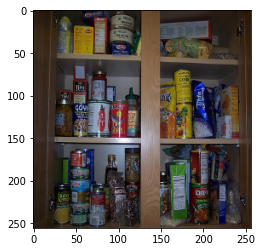

In [23]:

z, _ = next(iter(val_loader))
print(z.mean(), z.std())
img_norm = z[0].permute(1, 2, 0).numpy()
plt.imshow(img_norm)

In [11]:
from sklearn import metrics
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        #view_classify(data.cpu(), pred.cpu() )
        #print(metrics.classification_report(target.cpu(), pred.cpu(),zero_division=0))
        #print(plt.imshow(img_norm))
    val_loss /= len(val_loader)
    loss_vector.append(val_loss)

    

    accuracy = 100. * correct.to(torch.float32) / len(val_loader.dataset)
    accuracy_vector.append(accuracy)

        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), accuracy))


In [12]:
#Definisco una funzione per stampare la label predetta e quella corretta

def Predic(loss_vector,accuracy_vector):
    val_loss, correct = 0, 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
    print(pred)
    print("/n")
    print(target)


In [40]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [13]:
lossv, accv = [], []
for epoch in range(1, num_epochs + 1):
    train(epoch)
    validate(lossv, accv)
    Predic(lossv,accv)

Train Epoch: 1 [0/1000 (0%)]	Loss: 7.301862
Train Epoch: 1 [640/1000 (62%)]	Loss: 6.763541

Validation set: Average loss: 6.3848, Accuracy: 1/100 (1%)

tensor([181, 358, 181, 254], device='cuda:0')
/n
tensor([111, 127, 316, 224], device='cuda:0')
Train Epoch: 2 [0/1000 (0%)]	Loss: 5.708561
Train Epoch: 2 [640/1000 (62%)]	Loss: 5.176608

Validation set: Average loss: 6.0517, Accuracy: 1/100 (1%)

tensor([  2, 234, 327, 358], device='cuda:0')
/n
tensor([ 63, 118, 244, 174], device='cuda:0')
Train Epoch: 3 [0/1000 (0%)]	Loss: 3.845865
Train Epoch: 3 [640/1000 (62%)]	Loss: 3.470898

Validation set: Average loss: 6.1933, Accuracy: 4/100 (4%)

tensor([ 69, 582, 193, 854], device='cuda:0')
/n
tensor([216, 338, 279, 269], device='cuda:0')
Train Epoch: 4 [0/1000 (0%)]	Loss: 2.209947
Train Epoch: 4 [640/1000 (62%)]	Loss: 1.599613

Validation set: Average loss: 5.5380, Accuracy: 6/100 (6%)

tensor([ 48, 404, 200, 884], device='cuda:0')
/n
tensor([ 97, 309, 217,  84], device='cuda:0')
Train Epoch:

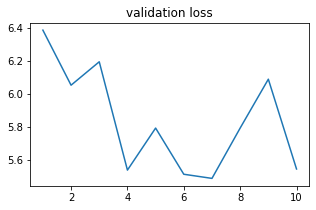

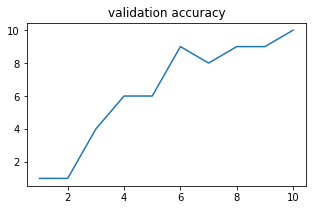

In [14]:

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,num_epochs+1), accv)
plt.title('validation accuracy');
     

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(img)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[yb[0].item()]

In [ ]:
z, _ = next(iter(val_loader))
plt.imshow(z[0].permute(1, 2, 0).numpy())
print('Predicted:', predict_image(z, model.cpu()))
